In [2]:
import numpy as np 
import pandas as pd 
import os

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential , layers
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import matplotlib.pyplot as plt
import seaborn as sns

2025-11-02 11:39:37.588569: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762083577.791127      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762083577.843026      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
target = (224,224)
batch=64
generator = ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet50.preprocess_input,rescale=1/255)
data_dir = "/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)"
# traingen = generator.flow_from_directory("/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train/",target_size=target,batch_size=batch,color_mode="rgb",class_mode="sparse")
# validgen = generator.flow_from_directory("/kaggle/input/new-plant-diseases-dataset/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid/",target_size=target,batch_size=batch,color_mode="rgb",class_mode="sparse")
# testgen = generator.flow_from_directory(
#     "/kaggle/input/new-plant-diseases-dataset/test/",
#     target_size=target,
#     batch_size=batch,
#     color_mode="rgb",
#     class_mode=None,  # ✅ No labels
#     shuffle=False     # ✅ Keep order consistent for predictions
# )


In [5]:
print("Creating the training dataset...")
train_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    image_size=target,
    batch_size=batch,
    shuffle=True  # Correct: Always shuffle training data
)

print("Creating the validation dataset...")
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'valid'),
    image_size=target,
    batch_size=batch,
    shuffle=False # Correct: No need to shuffle validation data
)

test_dir = "/kaggle/input/new-plant-diseases-dataset/test"
print("Test dir: ",os.path.join(test_dir, 'test'))
print("Creating the test dataset...")
test_dataset = tf.keras.utils.image_dataset_from_directory(
    os.path.join(test_dir, 'test'),
    image_size=target,
    batch_size=batch,
    labels=None, # Correct: No labels for a single-directory test set
    shuffle=False # Correct: Never shuffle test data
)

Creating the training dataset...
Found 70295 files belonging to 38 classes.


I0000 00:00:1762083636.858445      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Creating the validation dataset...
Found 17572 files belonging to 38 classes.
Test dir:  /kaggle/input/new-plant-diseases-dataset/test/test
Creating the test dataset...
Found 33 files.


In [6]:
class_names = train_dataset.class_names
print("Class names: ",class_names)

Class names:  ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Toma

In [7]:
base_layer = tf.keras.applications.ResNet50(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=(224,224,3),
    pooling=None,
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [8]:
model = Sequential([
    base_layer,                              
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dense(2048, activation='relu'),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.35),
    layers.BatchNormalization(),
    layers.Dense(38, activation='softmax')   
])

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    51,380,736 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2048)           │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 38)             │        38,950 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,734,182 (304.16 MB)

 Trainable params: 79,679,014 (303.95 MB)

 Non-trainable params: 55,168 (215.50 KB)

In [10]:
from tensorflow.keras import optimizers
model.compile(
    optimizer = optimizers.Adam(learning_rate=0.00075),
    loss="sparse_categorical_crossentropy",
    metrics = ["accuracy"],
)

In [11]:
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset
)

Epoch 1/5


I0000 00:00:1762083698.362875     104 service.cc:148] XLA service 0x7e0fac004930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762083698.363482     104 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1762083703.193487     104 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762083729.856256     104 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1099/1099 ━━━━━━━━━━━━━━━━━━━━ 446s 332ms/step - accuracy: 0.7258 - loss: 1.0093 - val_accuracy: 0.8747 - val_loss: 0.5132
Epoch 2/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 322s 293ms/step - accuracy: 0.9624 - loss: 0.1306 - val_accuracy: 0.7983 - val_loss: 0.7913
Epoch 3/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 323s 293ms/step - accuracy: 0.9751 - loss: 0.0829 - val_accuracy: 0.8819 - val_loss: 0.5850
Epoch 4/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 322s 293ms/step - accuracy: 0.9732 - loss: 0.0938 - val_accuracy: 0.8592 - val_loss: 0.6229
Epoch 5/5
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 322s 293ms/step - accuracy: 0.9844 - loss: 0.0551 - val_accuracy: 0.9585 - val_loss: 0.1511


In [12]:
# Assuming your 'model' is already compiled and trained
test_loss, test_acc = model.evaluate(validation_dataset, verbose=1)
print("Test Accuracy: ", test_acc)
print("Test Loss: ",test_loss)

275/275 ━━━━━━━━━━━━━━━━━━━━ 22s 80ms/step - accuracy: 0.9726 - loss: 0.0972
Test Accuracy:  0.9584566354751587
Test Loss:  0.1511184126138687


In [13]:
class_names_list = ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


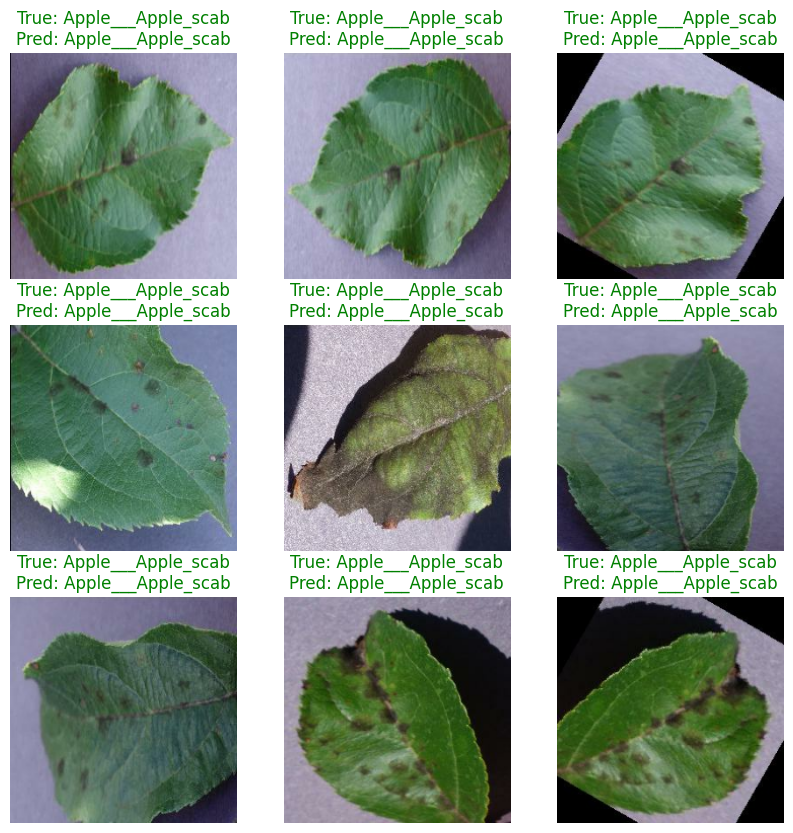

In [20]:
# Take one batch from the validation dataset
for images, true_labels in validation_dataset.take(2):
    # Get the model's predictions for this batch
    predictions = model.predict(images)

    # Plot the first 9 images and their predictions
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_index = np.argmax(predictions[i])
        
        # Get the class names
        true_class = class_names[np.argmax(true_labels[i])]
        predicted_class = class_names[predicted_index]

        # Display the result
        title_color = "green" if true_class == predicted_class else "red"
        plt.title(f"True: {true_class}\nPred: {predicted_class}", color=title_color)
        plt.axis("off")
    plt.show()
    break # Exit the loop after showing one batch

In [15]:
test_folder=os.path.join(test_dir, 'test')
model.save("PlantDisease.h5")

In [16]:
print(test_folder)

/kaggle/input/new-plant-diseases-dataset/test/test


In [17]:
loadedModel = tf.keras.models.load_model("./PlantDisease.h5")

In [18]:
def loadImg(imgPath): 
    img = tf.keras.preprocessing.image.load_img(imgPath, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0
    return img_array

def predictImagesInFolder(testFolder, model): 
    for dirpath, dirnames, filenames in os.walk(testFolder):    # unpack tuple properly
        for file in filenames:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):  # only image files
                img_path = os.path.join(dirpath, file)             # correct full path
                img = loadImg(img_path)
                predictions = model.predict(img)
                predicted_class = np.argmax(predictions, axis=1)
                print(f"Predicted class: {predicted_class[0]} | File: {file}")

In [19]:
predictImagesInFolder(test_folder, loadedModel)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: 30 | File: TomatoEarlyBlight6.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted class: 30 | File: TomatoYellowCurlVirus4.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class: 30 | File: TomatoYellowCurlVirus6.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted class: 30 | File: PotatoHealthy2.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
Predicted class: 30 | File: TomatoYellowCurlVirus5.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class: 30 | File: PotatoEarlyBlight2.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class: 30 | File: TomatoYellowCurlVirus3.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class: 30 | File: TomatoEarlyBlight3.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Predicted class: 30 | File: CornCommonRust2.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Predicted class: 30 | File: AppleScab3.JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Predicted class: 30 | File: TomatoEarlyBlight5.JPG
1/1 ━━━━━━━━━━━━━━━━━━